### Recap from previous Lab

* We explored PyTorch (PT) tensor support and drew parallelisms w.r.t. NumPy `ndarray`
* We experimented with some basic Machine Learning (ML) building blocks in PT
* We built our first, very simple Artificial Neural Network (ANN), a MultiLayer Perceptrion (MLP)

### Agenda for today

* Today we will be training a MLP using SGD and backpropagation
  * we will not be using the synthetic dataset we saw last lecture
  * we will be training our MLP on the MNIST dataset, which is a simple (in modern terms) dataset on which to train our ANNs

### Intro to MNIST

MNIST is a dataset for **handwritten digit recognition**.

![](img/mnist.png)

* The dataset is composed of 60,000 grayscale images
  * by default, the dataset is already split into a training set of 50,000 images, while the remaining 10,000 images make up the test/validation set
* Each image is composed of 28x28 pixel
* Only one digit is present in each image
  * thus, we will be classifying digits from 0 to 9 (10 classes)
* The digit is centered within the image

#### Downloading the data

Since we're not covering the handling of data in this specific tutorial, I have prepared an external script which will download the data and "pack" it into DataLoaders.
You just need to know that DataLoaders and Datasets are two different entities; namely, DataLoaders are build on top of Datasets and handle the creation of the mini-batches that will later be fed into the MLP for the training and testing phase.

The script returns both the DataLoaders and Datasets, in case you wanna play with them

In [1]:
import torch
from scripts import mnist
from matplotlib import pyplot as plt

minibatch_size_train = 256
minibatch_size_test = 512

trainloader, testloader, trainset, testset = mnist.get_data(batch_size_train=minibatch_size_test, batch_size_test=minibatch_size_test)

Let us quickly view our data

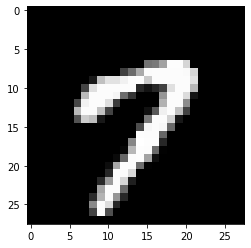

In [7]:
plt.imshow(trainset.data[15].numpy(), cmap="gray")

By applying the `Tensor` skills we learned during the previous lab, we may also plot multiple images within the same plot.


In [31]:
multi_img = trainset.data[25:30]
multi_img.shape

torch.Size([5, 28, 28])

We have a (5 x 28 x 28) `Tensor`, we can't plot it with `plt.imshow` because it needs a matrix as input.

**Q**: how can we solve this problem? Think about the methods we saw during the last lab

In [ ]:
# solve here

#### Designing our MLP

Let us design our MLP.

We need to think about:

1. How wide is the output layer?
2. How wide is the input layer and how is it structured?
3. How many hidden layers and how wide need they be?
4. What activation functions will we be using?

You may try answering questions 1 and 2 by yourself as there's only one specific answer.
Q. 3 and 4, instead, are a choice operated by the designer (the data scientist) and there is no straight definite answer, as usually architectural features are treated as hyperparameters to be tuned as part of the training process.

For our MLP, then, we will be designing an MLP with
* 3 hidden layers
  * the first hidden layer has 16 neurons
  * the second hidden layer has 32 neurons
  * the third hidden layer has 24 neurons
* ReLU as activation function for the hidden layers
* Cross Entropy loss (or, equivalently, Negative LogLikelihood loss)

![](img/mlp_mnist.png)

In [ ]:
# write here the class for your MLP
class MLP(torch.nn.Module):
    def __init__(self):
        pass
    def forward(self, X):
        pass

In [46]:
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.flat = torch.nn.Flatten()
        self.h1 = torch.nn.Linear(28*28, 16)
        self.h2 = torch.nn.Linear(16, 32)
        self.h3 = torch.nn.Linear(32, 24)
        self.out = torch.nn.Linear(24, 10)
    def forward(self, X):
        out = self.flat(X)
        out = torch.nn.functional.relu(self.h1(out))
        out = torch.nn.functional.relu(self.h2(out))
        out = torch.nn.functional.relu(self.h3(out))
        out = self.out(out)
        return out

#### The training loop

We now have to train the network using mini-batch Stochastic Gradient Descent (which we'll indicate as SGD).

The mini-batch part is already handled by the `DataLoader`.

We just need to call


```python
for X, y in dataloader:
    # do something
```

`X` and `y` represent our mini-batch (images and ground truth respectively).

* What do we need to do inside this loop?
  1. do the forward pass
  2. calculate the loss
  3. do the backward pass and update the parameters
* What objects do we need inside this loop?
  * the model (to do the forward pass)
  * the dataloader (to get `X, y`)
  * the loss function (to calculate the value of the loss and backpropagate)
  * the optimizer (to upgrade the value of the parameters given the gradients obtained via backprop)
* What do we need to do outside this loop?
  1. re-shuffle the mini-batches (NB: already taken care of by the `DataLoader`)
  2. repeat the loop for each epoch

Next, we are going to implement this loop (which we'll call `train_epoch`) in a minimalistic setting, i.e., with no excessive feature or embellishment.
  



In [47]:
def train_epoch(model, dataloader, loss_fn, optimizer):
    for X, y in dataloader:
        # 1. reset the gradients previously accumulated by the optimizer
        #    this will avoid re-using gradients from previous loops
        optimizer.zero_grad() 
        # 2. get the predictions from the current state of the model
        #    this is the forward pass
        y_hat = model(X)
        # 3. calculate the loss on the current mini-batch
        loss = loss_fn(y_hat, y)
        # 4. execute the backward pass given the current loss
        loss.backward()
        # 5. update the value of the params
        optimizer.step()

To work, we just need to wrap this routine inside another loop which will repeat `train_epoch` for each epoch.

In [65]:
def train_model(model, dataloader, loss_fn, optimizer, num_epochs):
    # this is a useful switch that lets us pass to training phase to network evaluation
    # we will see in a future lab why it is necessary - for now it does nothing in particular
    model.train()
    for epoch in range(num_epochs):
        train_epoch(model, dataloader, loss_fn, optimizer)
        print(f"Epoch {epoch+1} completed.") # this is just so we have an idea on where we are during the training

We will use vanilla SGD with a learning rate of 0.001 and we'll run the training for 3 epochs.
Moreover, we will use the Cross Entropy loss function.

In [56]:
learn_rate = 0.001
num_epochs = 3

model = MLP()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learn_rate)

In [57]:
train_model(model, trainloader, loss_fn, optimizer, num_epochs)

Ended epoch 0
Ended epoch 1
Ended epoch 2
Ended epoch 3
Ended epoch 4


The problem with this setting is that we have no idea how the network is faring, either on the training or the test set.

We need to devise some ways to assess the model.

Three ideas:

1. Accumulate the loss for each epoch
  * Alternatively, use the average loss per instance
2. Show the mean accuracy for each epoch
3. 1 and 2, but calculated on the test set

1 is easily implementable, just introduce a variable to accumulate the loss during the epoch and print it at the end of the training.

For 2 we need also to store the number of data points we have seen up to the current mini-batch. Recalling the concept of cumulative weighted average (CWA) for a time-dependent entity $x_t,~ t\in\{0,...,T\}$:

$\text{CWA}_t = \frac{ n_{0 : t-1} \cdot \text{CWA}_{t-1} + n_t \cdot x_t }{n_{0 : t-1} + n_t}$

where $n_t$ is the weight of the $t$-th observation $x_t$, while $n_{0 : t-1}$ is the cumulative weight of the observations from time instant $0$ to $t-1$.

In [60]:
def train_epoch(model, dataloader, loss_fn, optimizer, loss_cwa, cum_num_instances):
    for X, y in dataloader:
        # 1. reset the gradients previously accumulated by the optimizer
        #    this will avoid re-using gradients from previous loops
        optimizer.zero_grad() 
        # 2. get the predictions from the current state of the model
        #    this is the forward pass
        y_hat = model(X)
        # 3. calculate the loss on the current mini-batch
        loss = loss_fn(y_hat, y)
        # 4. execute the backward pass given the current loss
        loss.backward()
        # 5. update the value of the params
        optimizer.step()
        # 6. update the cumulative weighted average of the loss
        # a. obtain size of mini-batch
        current_n = X.shape[0]
        # b. update the CWA
        loss_cwa = (loss_cwa * cum_num_instances + loss.item() * current_n) / (cum_num_instances + current_n)
        # c. update the cumulative number of instances seen
        cum_num_instances += current_n

def train_model(model, dataloader, loss_fn, optimizer, num_epochs):
    for epoch in range(num_epochs):
        loss_cwa = 0.0
        cum_num_instances = 0
        train_epoch(model, dataloader, loss_fn, optimizer, loss_cwa, cum_num_instances)
        print(f"Epoch {epoch+1} completed. Cumulative average of training loss: {loss_cwa}")

Usually, though, since passing parameters like `loss_cwa` and `cum_num_instances` is a bit of a bloater, we usually employ a small class to keep track of all the performance parameter we need to measure. In the PT programming environment we call it `AverageMeter` and is implemented like so

In [61]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [62]:
def train_epoch(model, dataloader, loss_fn, optimizer, loss_meter):
    for X, y in dataloader:
        # 1. reset the gradients previously accumulated by the optimizer
        #    this will avoid re-using gradients from previous loops
        optimizer.zero_grad() 
        # 2. get the predictions from the current state of the model
        #    this is the forward pass
        y_hat = model(X)
        # 3. calculate the loss on the current mini-batch
        loss = loss_fn(y_hat, y)
        # 4. execute the backward pass given the current loss
        loss.backward()
        # 5. update the value of the params
        optimizer.step()
        # 6. update the loss AverageMeter
        loss_meter.update(val=loss.item(), n=X.shape[0])

def train_model(model, dataloader, loss_fn, optimizer, num_epochs):
    for epoch in range(num_epochs):
        loss_meter = AverageMeter() # zero out average meter -- we are only keeping track of performance through each epoch
        train_epoch(model, dataloader, loss_fn, optimizer, loss_meter)
        # now with loss meter we can print both the cumulative value and the average value
        print(f"Epoch {epoch+1} completed. Loss - total: {loss_meter.sum} - average: {loss_meter.avg}")

#### Assessing accuracy

Usually, $\text{loss} \in [0;+\infty)$, so it is hard to assess the effectiveness of the ANN based solely on such value.

Alongside a loss, we can assess the performance via a much more interpretable index as the **accuracy**

$\text{accuracy} = \frac{\text{# correctly identified items}}{\text{# all items}}$

To keep track of the accuracy, we can re-use the AverageMeter defined above, although we need to define a function for it---since PT does not implement it by default.

In [ ]:
def accuracy(y_hat, y):
    '''
    y_hat is the model output - a Tensor of shape (n x num_classes)
    y is the ground truth

    How can we implement this function?
    '''

    pass

In [64]:
def train_epoch(model, dataloader, loss_fn, optimizer, loss_meter, accuracy_meter):
    for X, y in dataloader:
        # 1. reset the gradients previously accumulated by the optimizer
        #    this will avoid re-using gradients from previous loops
        optimizer.zero_grad() 
        # 2. get the predictions from the current state of the model
        #    this is the forward pass
        y_hat = model(X)
        # 3. calculate the loss on the current mini-batch
        loss = loss_fn(y_hat, y)
        # 4. execute the backward pass given the current loss
        loss.backward()
        # 5. update the value of the params
        optimizer.step()
        # 6. calculate the accuracy for this mini-batch
        acc = accuracy(y_hat, y)
        # 7. update the loss and accuracy AverageMeter
        loss_meter.update(val=loss.item(), n=X.shape[0])
        accuracy_meter.update(val=acc, n=X.shape[0])

def train_model(model, dataloader, loss_fn, optimizer, num_epochs):
    for epoch in range(num_epochs):
        loss_meter = AverageMeter()
        accuracy_meter = AverageMeter()
        train_epoch(model, dataloader, loss_fn, optimizer, loss_meter, accuracy_meter)
        # now with loss meter we can print both the cumulative value and the average value
        print(f"Epoch {epoch+1} completed. Loss - total: {loss_meter.sum} - average: {loss_meter.avg}; Accuracy: {accuracy_meter.avg}")
    # we also return the stats for the final epoch of training
    return loss_meter.sum, accuracy_meter.avg

*Additional observation*: we might wanna pass the `accuracy` as an additional `performance` parameter (analogous to `loss_fn`) since we might wanna evaluate the performance on a metric different than accuracy.

Now, we can train the network and examine its performance as we're running the training

In [ ]:
# reset the network and optimizer
model = MLP()
optimizer = torch.optim.SGD(model.parameters(), lr=learn_rate)

loss, acc = train_model(model, trainloader, loss_fn, optimizer, num_epochs)
print(f"Training completed - final accuracy {acc} and loss {loss}")

Recall that we wanted to assess also the network's performance on the test set. We need an additional testing routine for it.

For testing, we need only

1. the network
2. the test-set `DataLoader`
3. the loss function / the performance metrics

we don't need the optimizer as we're not updating the weights now


In [66]:
def test_model(model, dataloader, loss_fn):
    loss_meter = AverageMeter()
    acc_meter = AverageMeter()
    model.eval() # this is the contrary of model.train() we saw before
    with torch.no_grad():
        for X, y in dataloader:
            y_hat = model(X)
            loss = loss_fn(y_hat, y)
            acc = accuracy(y_hat, y)
            loss_meter.update(loss.item(), X.shape[0])
            acc_meter.update(acc, X.shape[0])
    print(f"TESTING - loss {loss_meter.sum} - accuracy {acc_meter.avg}")


Now that we have nice-enough-looking training and testing routines and that we have trained and tested our model we might want to save it so we can re-use it in the future.

The model can be easily saved using the `state_dict()` method. Let's see what it is

In [67]:
model.state_dict()

7e-01,
                        1.0652e-01,  1.8291e-01,  2.2223e-01, -2.0207e-01, -1.5858e-01,
                       -9.1937e-02,  1.1120e-01, -1.5490e-01, -4.8807e-02,  2.2933e-01,
                        2.3567e-01],
                      [ 5.2622e-02, -1.8437e-01,  4.4377e-02,  1.2814e-01, -1.3595e-01,
                        2.1048e-01,  1.8734e-01,  6.4211e-02,  1.6523e-01, -4.8259e-02,
                        1.7182e-01, -1.5033e-01,  1.5700e-01, -1.6708e-02,  1.5608e-01,
                        2.0368e-01],
                      [ 1.8016e-01, -2.1795e-01,  1.0132e-01,  1.0164e-01, -2.1579e-01,
                       -1.9992e-01, -2.2767e-01,  1.1977e-01, -2.4566e-01,  6.1943e-02,
                        2.2872e-01,  6.8652e-03,  2.2777e-02,  1.0848e-01, -1.1707e-01,
                       -4.7729e-02],
                      [-2.2402e-01,  4.2225e-02, -2.1596e-01, -2.3719e-01,  2.3135e-01,
                       -8.9767e-02, -2.4510e-01,  2.3849e-01, -7.7952e-02, -2.3323e-01,
  

We can save it using PT built-in `torch.save`

In [70]:
import os
folder_save = "models/mlp_mnist"
os.makedirs(folder_save, exist_ok=True)
filename = os.path.join(folder_save, "model.pt")
torch.save(model.state_dict(), filename)

Let's suppose we wish to reload the state_dict. We just need one line of code: 

In [71]:
model.load_state_dict(torch.load(filename))

<All keys matched successfully>

# TODO custom loss